In [1]:
import torch
import source as source
import image_encoder as encoder
import image_encoder.v2_trainer as v2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [2]:
loader_params = {
    'folder_path': 'data/training',
    'only_inputs': True,
    'percent_mask': 0.1,
    'pad_images': True,
    'transformation_depth': 2,
    'transformation_samples': 0,
    'p_use_base': 0.15,
    'shuffle': True
}

_, dataloader = v2.get_pcfg_datahandlers(**loader_params)
ViT = encoder.v2.VisionTransformer.load_model("image_encoder/v2_trainer/trained_models_v2/vit_12-05-24_300k_v4.pth", print_statements=True, device=device)
# ViT, t_embs = encoder.VisionTransformer.load_model(f"image_encoder/trained_models/vit_11-21-24_400k_vF.pth", print_statements=True, device=device)
ViT = ViT.to(device)

C:\Users\lucas\Desktop\UCSD\291C - Program Synthesis\Project\ARC-AGI\image_encoder\v2_trainer\vision_transformer_v2.py:222: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  che

Vision Transformer instantiated with 398,144 parameters using Sinusoidal encodings.


# Visualizing Our Attention

In [3]:
sample_u, sample_attn = None, None
with torch.no_grad():
    ViT.eval()
    for i, (ids, u, _, _, _) in enumerate(dataloader):
        B, H, W = u.shape
        u = u.to(device)

        # Forward pass
        cls_logits, patch_logits, attn = ViT(u, save_attn=True, temperature=1)

        sample_attn = attn[0][0].cpu()
        sample_u = u[0].cpu()
        break

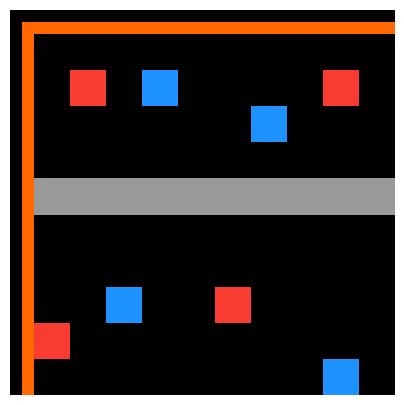

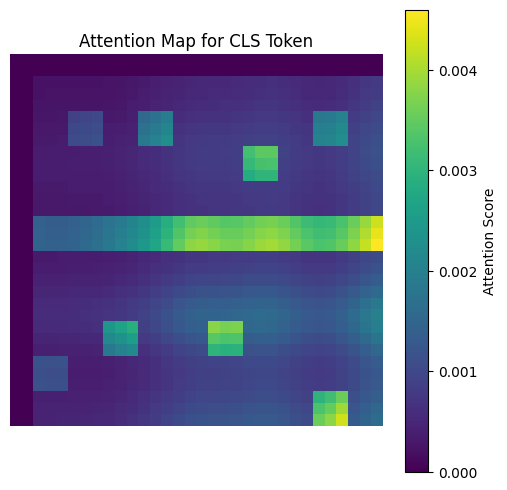

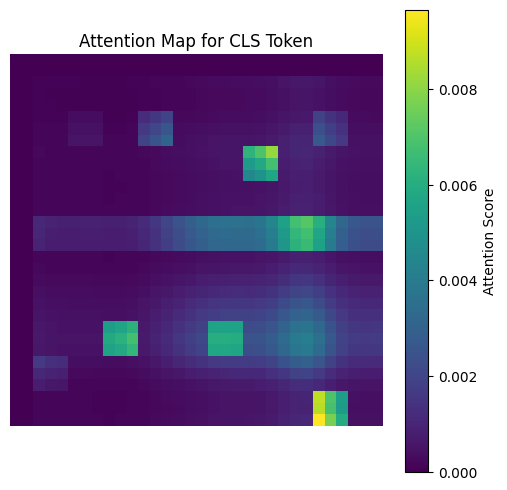

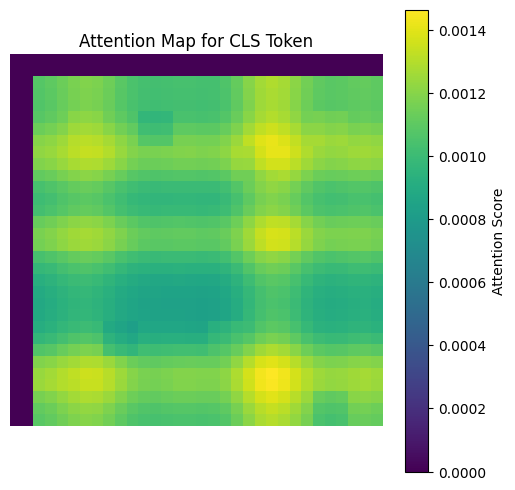

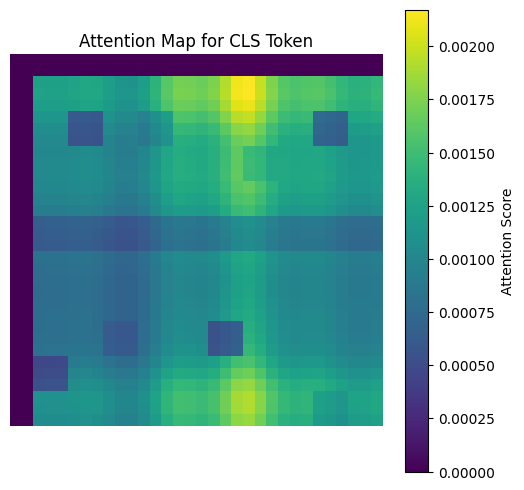

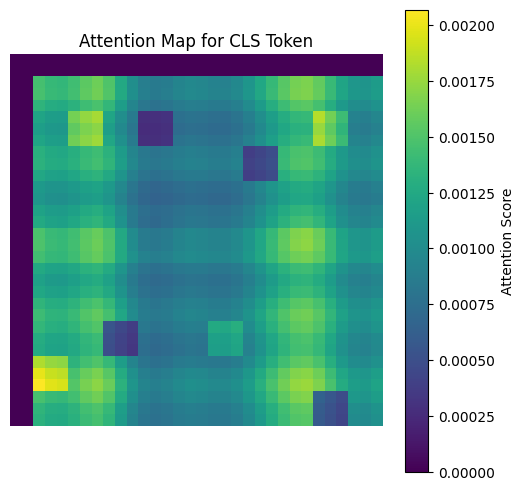

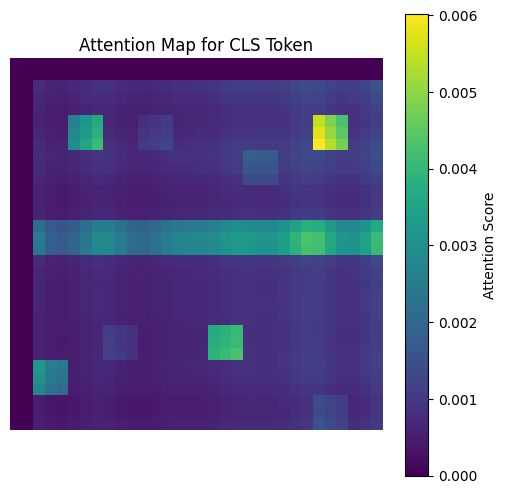

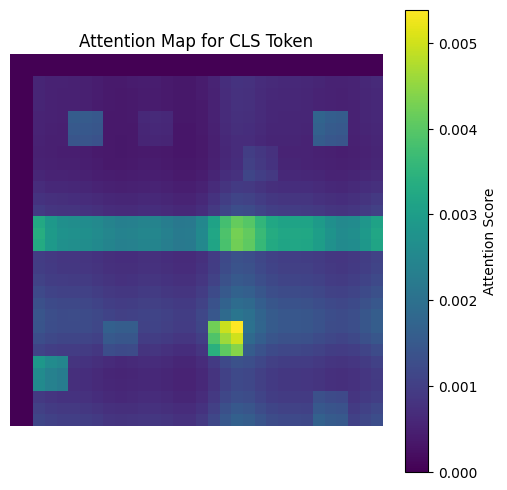

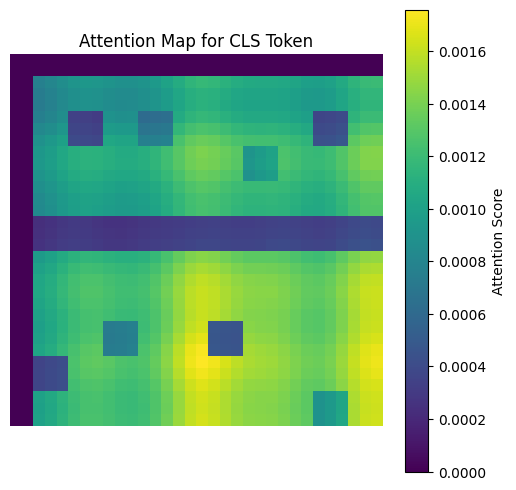

In [4]:
idx = encoder.get_idx(x=15, y=15, CLS=True, size=sample_u.shape)
encoder.plot_tensor_with_highlight(sample_u, idx)
encoder.plot_attention_map(sample_attn[0], idx, size=sample_u.shape)
encoder.plot_attention_map(sample_attn[1], idx, size=sample_u.shape)
encoder.plot_attention_map(sample_attn[2], idx, size=sample_u.shape)
encoder.plot_attention_map(sample_attn[3], idx, size=sample_u.shape)
encoder.plot_attention_map(sample_attn[4], idx, size=sample_u.shape)
encoder.plot_attention_map(sample_attn[5], idx, size=sample_u.shape)
encoder.plot_attention_map(sample_attn[6], idx, size=sample_u.shape)
encoder.plot_attention_map(sample_attn[7], idx, size=sample_u.shape)

# Cosine Sim on CLS Token

In [5]:
# This will take some time -- it is generating CLS token embeddings for all images in the dataset
ids_list = []
images_tensor = []
cls_tensor = []

with torch.no_grad():
    ViT.eval()
    for i, (ids, u, _, _, _) in enumerate(dataloader):
        B, H, W = u.shape
        u = u.to(device)

        cls_logits, _, _ = ViT(u, save_attn=False, temperature=1)

        ids_list.extend(ids)
        images_tensor.append(u.cpu())
        cls_tensor.append(cls_logits[:, 0].cpu())
        if i > 10:
            break
        
    images_tensor = torch.cat(images_tensor, dim=0)
    cls_tensor = torch.cat(cls_tensor, dim=0)

Reference Image


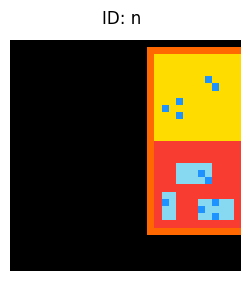





Closest 5 images:


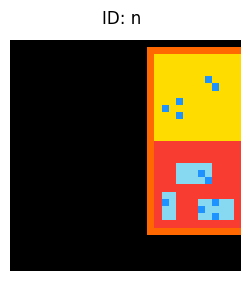

Similarity = 1.000



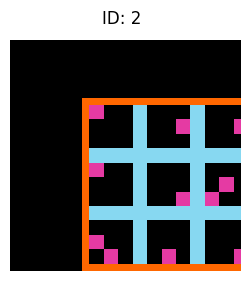

Similarity = 0.522



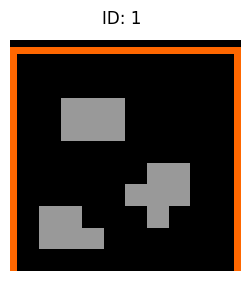

Similarity = 0.498



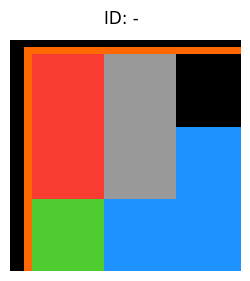

Similarity = 0.285



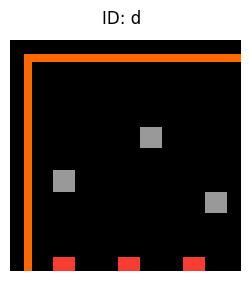

Similarity = 0.066




Furthest 5 images:


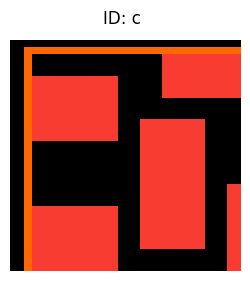

Similarity = -0.145



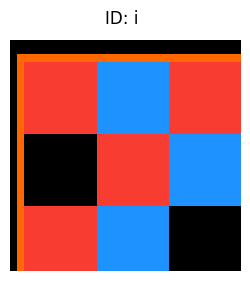

Similarity = -0.134



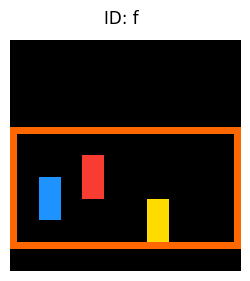

Similarity = -0.130



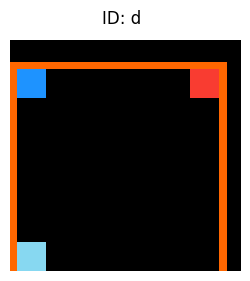

Similarity = -0.121



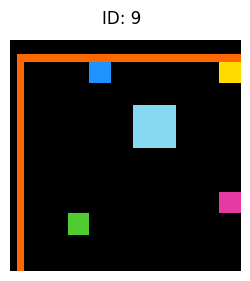

Similarity = -0.082



In [6]:
# Compute cosine similarity for given id
# id  = 'd4a91cb9-train-output-1'
# idx = ids_list.index(id)
idx = 10

print(f"Reference Image")
encoder.plot_tensors_with_colors(images_tensor[idx:idx+1], f"ID: {ids_list[idx]}")
print(f"{'='*60}\n")

# Compute our closest and furthest embeddings
k = 5
closest_embeddings, closest_sims = encoder.top_k_cosine_similarity(cls_tensor, idx, k, largest=True)
furthest_embeddings, furthest_sims = encoder.top_k_cosine_similarity(cls_tensor, idx, k, largest=False)


print(f"\n\n\nClosest {k} images:")
for i, closest_idx in enumerate(closest_embeddings):
    closest_id = ids_list[closest_idx]
    encoder.plot_tensors_with_colors(images_tensor[closest_idx:closest_idx+1], f"ID: {closest_id}")
    print(f"Similarity = {closest_sims[i]:.3f}\n")

print(f"\n\n\nFurthest {k} images:")
for i, furthest_idx in enumerate(furthest_embeddings):
    furthest_id = ids_list[furthest_idx]
    encoder.plot_tensors_with_colors(images_tensor[furthest_idx:furthest_idx+1], f"ID: {furthest_id}")
    print(f"Similarity = {furthest_sims[i]:.3f}\n")

# Cosine Similarity Across Objects (Post Segmentation)

In [7]:
def extraction_helper(base_obj):
    obj_list = source.extract_objects(base_obj, 'contour_scale')
    if len(obj_list) > 12:
        obj_list = source.extract_objects(base_obj, 'color')
    return obj_list

def pad_to_32x32(image, place_central=True, offset=None):
    """Pads the input image tensor to 32x32 with custom padding rules."""
    height, width = image.shape        
    if height == 32 and width == 32:
        return image, (0, 0)
    
    # Create a 1-pixel border of '11' around the image
    bordered_image = torch.nn.functional.pad(image, (1, 1, 1, 1), value=11)
    cropped_image = bordered_image[:32, :32]    # Ensure 32 x 32
    height, width = cropped_image.shape
    pad_bottom = max(0, 32 - height)
    pad_right = max(0, 32 - width)
    
    # Determine offset
    if place_central:
        x = pad_right // 2
        y = pad_bottom // 2
    elif offset is not None:
        x, y = offset
    else:
        x, y = 0, 0
    
    # Pad to place the image within the 32x32 frame
    padded_image = torch.nn.functional.pad(
        cropped_image, 
        (x, pad_right - x, y, pad_bottom - y), 
        value=12
    )
    return padded_image, (x, y)        

In [8]:
# This will take some time -- it is generating CLS token embeddings for all images in the dataset
ids_list = []
images_tensor = []
cls_tensor = []

with torch.no_grad():
    ViT.eval()
    for i, (ids, u, _, _, _) in enumerate(dataloader):
        B, H, W = u.shape
        if B > 1:
            raise ValueError("B should be 1")
        
        im_r, im_c = torch.where(u[0] < 10)
        min_row, max_row = im_r.min().item(), im_r.max().item()
        min_col, max_col = im_c.min().item(), im_c.max().item()
        t_u = u[0, min_row:max_row + 1, min_col:max_col + 1].numpy()
        
        base_obj = source.ARC_Object(t_u)
        obj_list = extraction_helper(base_obj)
        for j, obj in enumerate(obj_list):
            obj.set_embedding(ViT)
            new_id = str(ids[0]) + '-' + str(j)
            ids_list.append(new_id)
            im_tens, _ = pad_to_32x32(torch.tensor(obj.grid))
            im_tens = im_tens.reshape((1, 32, 32))
            images_tensor.append(im_tens.cpu())
            cls_tensor.append(obj.embedding.reshape(1, -1))
        if i > 100:
            break
        
    images_tensor = torch.cat(images_tensor, dim=0)
    cls_tensor = torch.cat(cls_tensor, dim=0)

Reference Image


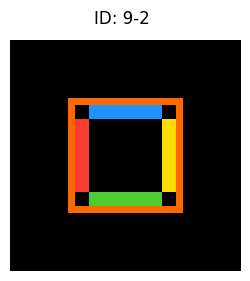


torch.Size([416, 64])



Closest 5 images:


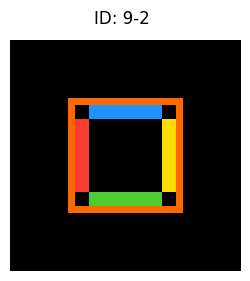

Similarity = 1.000



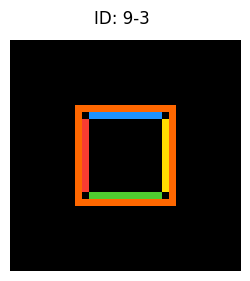

Similarity = 0.808



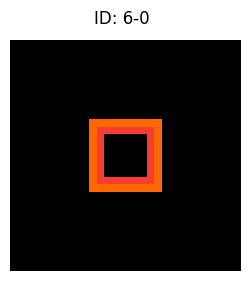

Similarity = 0.326



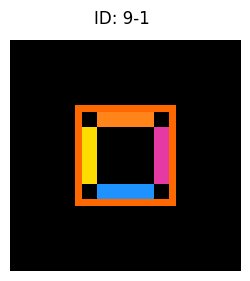

Similarity = 0.288



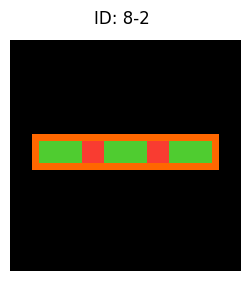

Similarity = 0.283




Furthest 5 images:


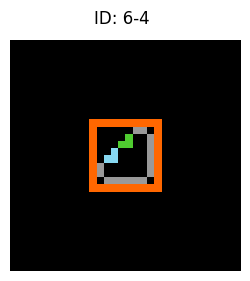

Similarity = -0.558



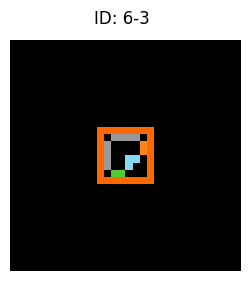

Similarity = -0.505



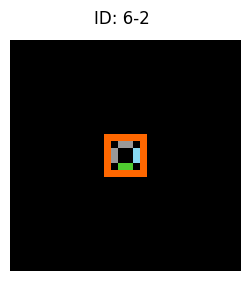

Similarity = -0.438



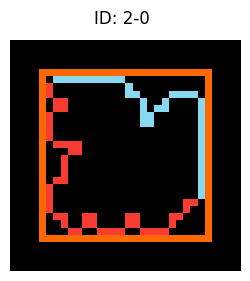

Similarity = -0.394



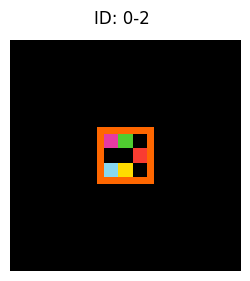

Similarity = -0.318



In [11]:
# Compute cosine similarity for given id
# id  = 'd4a91cb9-train-output-1'
# idx = ids_list.index(id)
idx = 13

print(f"Reference Image")
encoder.plot_tensors_with_colors(images_tensor[idx:idx+1], f"ID: {ids_list[idx]}")
print(f"{'='*60}\n")
print(cls_tensor.shape)

# Compute our closest and furthest embeddings
k = 5
closest_embeddings, closest_sims = encoder.top_k_cosine_similarity(cls_tensor, idx, k, largest=True)
furthest_embeddings, furthest_sims = encoder.top_k_cosine_similarity(cls_tensor, idx, k, largest=False)


print(f"\n\n\nClosest {k} images:")
for i, closest_idx in enumerate(closest_embeddings):
    closest_id = ids_list[closest_idx]
    encoder.plot_tensors_with_colors(images_tensor[closest_idx:closest_idx+1], f"ID: {closest_id}")
    print(f"Similarity = {closest_sims[i]:.3f}\n")

print(f"\n\n\nFurthest {k} images:")
for i, furthest_idx in enumerate(furthest_embeddings):
    furthest_id = ids_list[furthest_idx]
    encoder.plot_tensors_with_colors(images_tensor[furthest_idx:furthest_idx+1], f"ID: {furthest_id}")
    print(f"Similarity = {furthest_sims[i]:.3f}\n")